In [3]:
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2
from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline

Lets start by analyzing the number of images in each class for the training set

In [4]:
pneumonia_train = list(paths.list_images("chest_xray/train/PNEUMONIA/"))
normal_train = list(paths.list_images("chest_xray/train/NORMAL/"))
print(len(pneumonia_train))
print(len(normal_train))

3875
1341


### 1. Explanatory Analysis
Let's go into each class and randomly display some images to get an idea of how they look. But first lets make a function to do this for us.

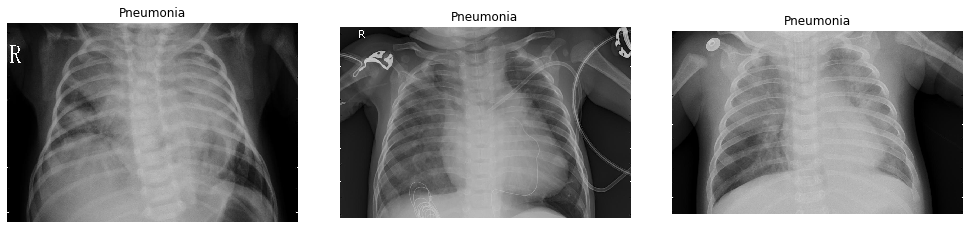

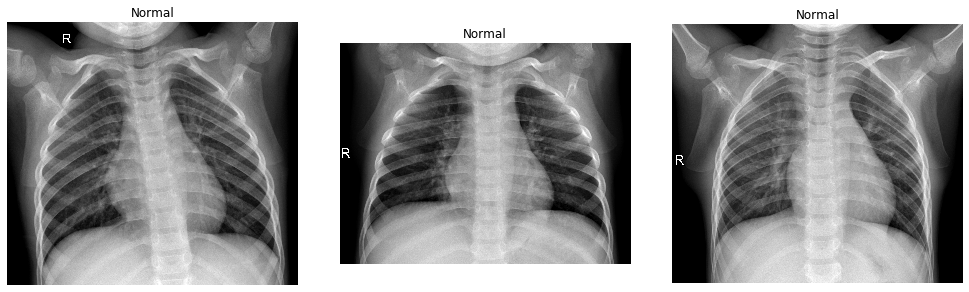

In [6]:
# function to read images
def read_image(im_path, rgb=True):
    im = cv2.imread(im_path)
    if rgb:
        return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

# define classes
columns = 3
classes = {
    "Pneumonia":[read_image(img) for img in random.sample(pneumonia_train, columns)], 
    "Normal": [read_image(img) for img in random.sample(normal_train, columns)]
}
# this method displays images for two classes based adjacent to each other
def display(classes, columns, read_as_rgb=True):
    for _class in classes:
        #print(random_images)
        fig, axes = plt.subplots(nrows=1, ncols=columns, figsize=(14, 10), squeeze=False)
        fig.tight_layout()
        for l in range(1):
            for m, img in enumerate(classes[_class]):
                axes[l][m].imshow(img)
                axes[l][m].axis("off")
                axes[l][m].set_title(_class)
    # done displaying
    
# display images
display(classes, columns)

Let us do some preprocessing that will bring up the contrast in the images. The approach is,

-> RGB -> HSV -> H, S, V -> H, S, HistogramEqulize(V) -> HSV -> RGB

In [7]:
def preprocess(image):
    # BGR to HSV
    img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # split to H,S,V
    H, S, V = cv2.split(img)
    # histogram equalize
    V = cv2.equalizeHist(V)
    # join back
    img = cv2.merge([H, S, V])
    # HSV to RGB
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    
    return img

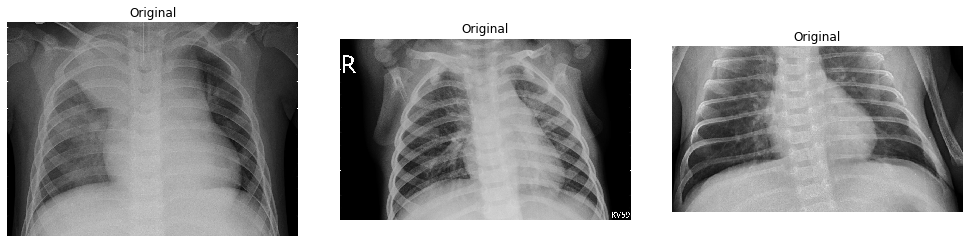

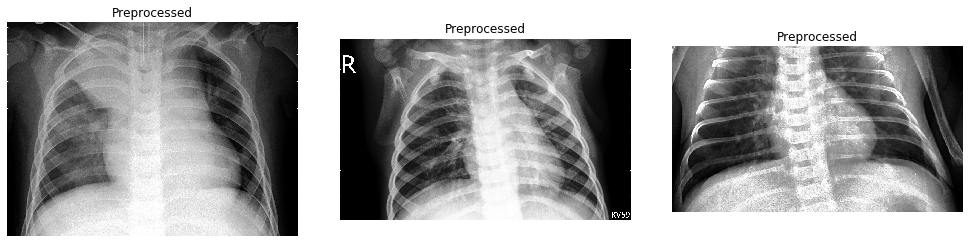

In [8]:
# get some random positive images
sample_positive = random.sample(pneumonia_train, 3)

# make a dictionary regular samples and preprocessed ones
classes = {
    "Original": [read_image(img) for img in sample_positive],
    "Preprocessed": [preprocess(read_image(img, rgb=False)) for img in sample_positive]
}

# display the images 
display(classes, 3)

### 2. Data Preprocessing and Augumentation

In this section we will generate and standardize data to address class imbalance problem

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

try:
    from imutils import paths
except ModuleNotFoundError:
    !pip install imutils
    from imutils import paths

_generator = ImageDataGenerator(
    width_shift_range=0.001,
    height_shift_range=0.001,
    zoom_range=0.01,
    horizontal_flip=True,
    rotation_range=0.99
)

In [43]:
def load_images(directory):
    image_paths = list(paths.list_images(directory))
    images = []
    for i, im_path in enumerate(image_paths):
        # read 
        image = cv2.imread(im_path)
        # bgr2rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # resize
        image = cv2.resize(image, (256, 256))
        # append
        images.append(image)
    _images = [img_to_array(image, data_format="channels_last") for image in images]
    _images = np.array(_images, dtype="float")
    #_images = _images.astype("float")
    return _images

In [44]:
X  = load_images(directory=os.path.join(os.getcwd(), "chest_xray/val/NORMAL/"))

In [26]:
X.shape

(1341,)

In [27]:
if os.path.exists("chest_xray/train/NORMAL/.ipynb_checkpoints/"):
    shutil.rmtree("chest_xray/train/NORMAL/.ipynb_checkpoints/")
X_aug = _generator.flow(
    x=X,
    y=None,
    save_to_dir="chest_xray/train/NORMAL/",
    save_format="jpeg",
    save_prefix="augumented"
)
for i in range(int(np.ceil((3500 - X.shape[0])/32))):
    x = next(X_aug)

ValueError: setting an array element with a sequence.